In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

In [3]:
sys.path.append("../../pytorch-cifar/models/")
import resnet
from resnet import ResNet18, ResNet50

### load the images

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])

In [5]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=[0.4914, 0.4822, 0.4465],
                                               std=[0.2023, 0.1994, 0.2010])

In [6]:
# data
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, 
                                          transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(
        cifar_test,
        batch_size=32,
        shuffle=False
    )

Files already downloaded and verified


In [7]:
dataiter = iter(test_loader)
image, label = next(dataiter)
idx=10
img = image[idx].unsqueeze(dim=0).to(device) # unnormalized
img_label = label[idx]

In [8]:

##
p_img = {"standard": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0},
         "CURE": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}}
###
for i in ["standard", "CURE", "adv_train_RN50"]:
    for j in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for file in os.listdir("../examples/output_expl_cifar/"+i+"/"+j):
            if file.startswith("x_"):
                p_img[i][j] = torch.load("../examples/output_expl_cifar/"+i+"/"+j+"/"+file)

In [9]:
# models
model_adv_train = ResNet50()
model_adv_train.load_state_dict(torch.load("models/RN50_linf_8_model_only.pt"))
model_adv_train = model_adv_train.eval().to(device)
######
model_cure = ResNet18()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)
######
model_standard = ResNet18()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)

In [10]:
# explanation for the standard network
expl_standard = get_expl(model_standard, normalizer.forward(img), "saliency", desired_index=img_label).detach().cpu()
torch.cuda.empty_cache()

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [11]:
# original explanations
expl_cure = get_expl(model_cure, normalizer.forward(img), "saliency", desired_index=img_label).detach().cpu()
torch.cuda.empty_cache()
expl_adv_train = get_expl(model_adv_train, normalizer.forward(img), "saliency", desired_index=img_label).detach().cpu()
torch.cuda.empty_cache()

#perturbed explanations
p_expl = {"standard": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0},
         "CURE": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}}

for i, method in enumerate(["standard", "CURE", "adv_train_RN50"]):
    for j, att in enumerate(["add", "add_stadv", "add_recolor", "add_stadv_recolor"]):
        perturbed_img = p_img[method][att]
        if method == "CURE":
            expl = get_expl(model_cure, normalizer.forward(perturbed_img), "saliency", desired_index=img_label)
        elif method == "adv_train_RN50":
            expl = get_expl(model_adv_train, normalizer.forward(perturbed_img), "saliency", desired_index=img_label)
        else:
            expl = get_expl(model_standard, normalizer.forward(perturbed_img), "saliency", desired_index=img_label)
        p_expl[method][att] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

### Visualize the results

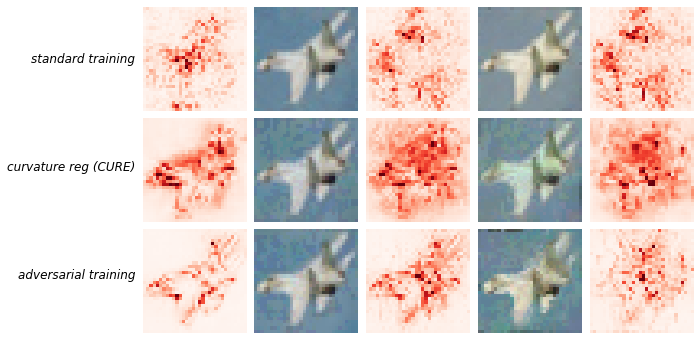

In [12]:


fig, ax = plt.subplots(3, 5, figsize=(10, 6))


viz.visualize_image_attr(np.transpose(expl_standard.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_cure.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)


for i, method in enumerate(["standard", "CURE", "adv_train_RN50"]):
    for j, att in enumerate(["add", "add_stadv_recolor"]):
        perturbed_img = p_img[method][att]
        ax[i, 2*j+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
        viz.visualize_image_attr(np.transpose(p_expl[method][att].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[i, 2*j+2]), use_pyplot=False)
#################
for i in range(3):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
# ax[0, 0].set_title("saliency", fontsize=12)
# ax[0, 1].set_title("smooth grad", fontsize=12)
# ax[0, 2].set_title("uniform grad", fontsize=12)
fig.text(0.12, 0.75, 'standard training', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.5, 'curvature reg (CURE)', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.25, 'adversarial training', style = 'oblique', fontsize = 12, horizontalalignment ='right')

# fig.text(0.12, 0.2, 'add+stadv+recolor', style = 'oblique', fontsize = 10, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("compare_attacks_viz_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [13]:
idx=8
target_img = image[idx].unsqueeze(dim=0).to(device)
target_img_label = label[idx]

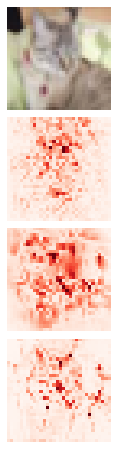

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(2, 8))
target_expl = get_expl(model_standard, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()

ax[0].imshow(torch_to_image(normalizer.forward(target_img), data_mean, data_std))
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(target_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

target_expl = get_expl(model_cure, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(target_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2]), use_pyplot=False)

target_expl = get_expl(model_adv_train, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(target_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[3]), use_pyplot=False)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("target_expl_map_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### Quantitative comparison

#### MSE

In [19]:
target_map = {"standard": 0, "CURE": 0, "adv_train_RN50": 0}
target_map["standard"] = get_expl(model_standard, normalizer.forward(target_img), "saliency", normalize=True).detach().cpu()
torch.cuda.empty_cache()
#
target_map["CURE"] = get_expl(model_cure, normalizer.forward(target_img), "saliency", normalize=True).detach().cpu()
torch.cuda.empty_cache()
#
target_map["adv_train_RN50"] = get_expl(model_adv_train, normalizer.forward(target_img), "saliency", normalize=True).detach().cpu()
torch.cuda.empty_cache()


In [16]:
mse_to_target_map = {"standard": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0},
         "CURE": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}}

for method in ["standard", "CURE", "adv_train_RN50"]:
    for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
        normalized_p_expl = torch.sum(p_expl[method][att].squeeze(), 0, True)
        normalized_p_expl = normalized_p_expl / torch.sum(normalized_p_expl)
        mse_to_target_map[method][att] = F.mse_loss(target_map[method], normalized_p_expl)

In [17]:
mse_to_target_map

{'standard': {'add': tensor(1.1280e-06),
  'add_recolor': tensor(1.1401e-06),
  'add_stadv': tensor(1.1289e-06),
  'add_stadv_recolor': tensor(1.1115e-06)},
 'CURE': {'add': tensor(4.3712e-07),
  'add_recolor': tensor(3.0226e-07),
  'add_stadv': tensor(2.8092e-07),
  'add_stadv_recolor': tensor(2.2724e-07)},
 'adv_train_RN50': {'add': tensor(1.8830e-06),
  'add_recolor': tensor(8.4516e-07),
  'add_stadv': tensor(8.4185e-07),
  'add_stadv_recolor': tensor(6.1923e-07)}}

#### LPIPS similarity for images 

In [25]:
import lpips

In [26]:
lpips_dist = lpips.LPIPS(net='vgg')
if torch.cuda.is_available():
    lpips_dist.cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth


In [23]:
lpips_to_original_image = {"standard": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0},
         "CURE": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_recolor": 0, "add_stadv": 0, "add_stadv_recolor": 0}}
for method in ["standard", "CURE", "adv_train_RN50"]:
    for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
        lpips_to_original_image[method][att] = lpips_dist.forward(img, p_img[method][att]).item()

In [24]:
lpips_to_original_image

{'standard': {'add': 0.02012418396770954,
  'add_recolor': 0.033338505774736404,
  'add_stadv': 0.020160522311925888,
  'add_stadv_recolor': 0.029945751652121544},
 'CURE': {'add': 0.14090032875537872,
  'add_recolor': 0.20717161893844604,
  'add_stadv': 0.1827707290649414,
  'add_stadv_recolor': 0.2111307978630066},
 'adv_train_RN50': {'add': 0.09597763419151306,
  'add_recolor': 0.1862943172454834,
  'add_stadv': 0.19027695059776306,
  'add_stadv_recolor': 0.1976233422756195}}

#### visual quantitative results

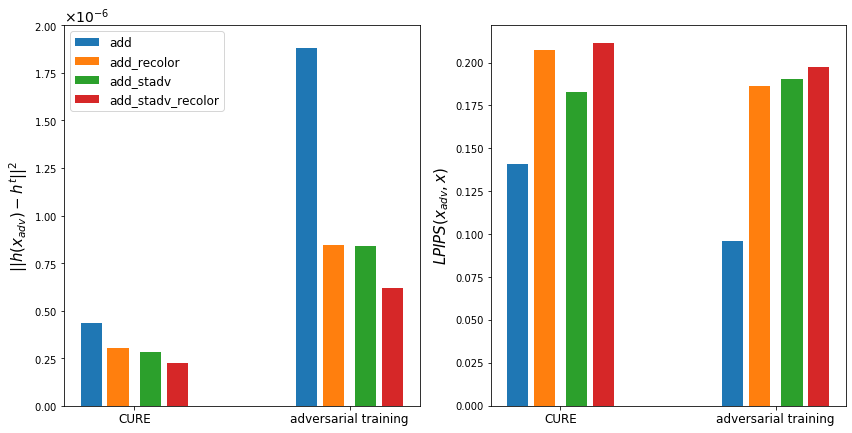

In [37]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

x_s = np.array([1,2])
ax[0].bar(x_s - 0.2, 
           [mse_to_target_map["CURE"]["add"], 
            mse_to_target_map["adv_train_RN50"]["add"]], width=0.1, label="add")

ax[0].bar(x_s - 0.075, 
           [mse_to_target_map["CURE"]["add_recolor"],
            mse_to_target_map["adv_train_RN50"]["add_recolor"]], width=0.1, label="add_recolor")

ax[0].bar(x_s + 0.075, 
           [mse_to_target_map["CURE"]["add_stadv"],
            mse_to_target_map["adv_train_RN50"]["add_stadv"]], width=0.1, label="add_stadv")

ax[0].bar(x_s + 0.2, 
           [mse_to_target_map["CURE"]["add_stadv_recolor"],
            mse_to_target_map["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="add_stadv_recolor")

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=2e-6)

ax[1].bar(x_s - 0.2, 
           [lpips_to_original_image["CURE"]["add"], 
            lpips_to_original_image["adv_train_RN50"]["add"]], width=0.1, label="add")

ax[1].bar(x_s - 0.075, 
           [lpips_to_original_image["CURE"]["add_recolor"],
            lpips_to_original_image["adv_train_RN50"]["add_recolor"]], width=0.1, label="add_recolor")

ax[1].bar(x_s + 0.075, 
           [lpips_to_original_image["CURE"]["add_stadv"],
            lpips_to_original_image["adv_train_RN50"]["add_stadv"]], width=0.1, label="add_stadv")

ax[1].bar(x_s + 0.2, 
           [lpips_to_original_image["CURE"]["add_stadv_recolor"],
            lpips_to_original_image["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="add_stadv_recolor")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### SSIM

In [12]:
ssim_similarity = SSIM()

In [13]:
ssim_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        ssim_to_original_map[att][method] = ssim_similarity.forward(org_map, p_expl[att][method])

In [14]:
ssim_to_original_map

{'add': {'saliency': tensor(0.4872),
  'smooth_grad': tensor(0.9801),
  'uniform_grad': tensor(0.9248)},
 'add_stadv': {'saliency': tensor(0.5004),
  'smooth_grad': tensor(0.9632),
  'uniform_grad': tensor(0.9183)},
 'add_recolor': {'saliency': tensor(0.4857),
  'smooth_grad': tensor(0.9748),
  'uniform_grad': tensor(0.9242)},
 'add_stadv_recolor': {'saliency': tensor(0.4955),
  'smooth_grad': tensor(0.9670),
  'uniform_grad': tensor(0.9122)}}

#### spearman rank-order correlation

In [15]:
from scipy.stats import spearmanr as spr
import scipy.spatial as spatial

In [16]:
spr_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        spr_to_original_map[att][method] = spr(org_map.flatten(), p_expl[att][method].flatten())[0]

In [17]:
spr_to_original_map

{'add': {'saliency': 0.13812864846985415,
  'smooth_grad': 0.6853185343601743,
  'uniform_grad': 0.6116536545388386},
 'add_stadv': {'saliency': 0.13435543310168865,
  'smooth_grad': 0.5847530882905764,
  'uniform_grad': 0.618118020844993},
 'add_recolor': {'saliency': 0.13082831144309479,
  'smooth_grad': 0.6399418571554515,
  'uniform_grad': 0.6441179753794173},
 'add_stadv_recolor': {'saliency': 0.13146664326413446,
  'smooth_grad': 0.6049617633483584,
  'uniform_grad': 0.595193332003895}}

#### cosine distance

In [18]:
cosd_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        cosd_to_original_map[att][method] = float(spatial.distance.cosine(org_map.flatten(), 
                                                                          p_expl[att][method].flatten()))

In [19]:
cosd_to_original_map

{'add': {'saliency': 0.5418198704719543,
  'smooth_grad': 0.16042709350585938,
  'uniform_grad': 0.21913832426071167},
 'add_stadv': {'saliency': 0.5500043332576752,
  'smooth_grad': 0.2441752552986145,
  'uniform_grad': 0.24832648038864136},
 'add_recolor': {'saliency': 0.5490026473999023,
  'smooth_grad': 0.18255573511123657,
  'uniform_grad': 0.23156660795211792},
 'add_stadv_recolor': {'saliency': 0.5533339083194733,
  'smooth_grad': 0.22555547952651978,
  'uniform_grad': 0.272874116897583}}

### CIEDE

In [15]:
##
p_img_ciede = {"CURE": {"add": 0, "add_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_reg": 0}}
###
for i in ["CURE", "adv_train_RN50"]:
    for j in ["add", "add_reg"]:
        for file in os.listdir("../examples/output_expl_cifar/ciede/"+i+"/"+j):
            if file.startswith("x_"):
                p_img_ciede[i][j] = torch.load("../examples/output_expl_cifar/ciede/"+i+"/"+j+"/"+file)

In [17]:

#perturbed explanations
p_expl_ciede = {"CURE": {"add": 0, "add_recolor": 0}, 
         "adv_train_RN50": {"add": 0, "add_reg": 0}}
for i, method in enumerate(["CURE", "adv_train_RN50"]):
    for j, att in enumerate(["add", "add_reg"]):
        perturbed_img = p_img_ciede[method][att]
        if method == "CURE":
            expl = get_expl(model_cure, normalizer.forward(perturbed_img), "saliency", desired_index=img_label)
        elif method == "adv_train_RN50":
            expl = get_expl(model_adv_train, normalizer.forward(perturbed_img), "saliency", desired_index=img_label)
        else:
            pass
        p_expl_ciede[method][att] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


#### MSE

In [22]:
mse_to_target_map_ciede = {"CURE": {"add": 0, "add_reg": 0}, 
         "adv_train_RN50": {"add": 0, "add_reg": 0}}

for method in ["CURE", "adv_train_RN50"]:
    for att in ["add", "add_reg"]:
        normalized_p_expl = torch.sum(p_expl_ciede[method][att].squeeze(), 0, True)
        normalized_p_expl = normalized_p_expl / torch.sum(normalized_p_expl)
        mse_to_target_map_ciede[method][att] = F.mse_loss(target_map[method], normalized_p_expl)

In [23]:
mse_to_target_map_ciede

{'CURE': {'add': tensor(2.1723e-07), 'add_reg': tensor(2.3867e-07)},
 'adv_train_RN50': {'add': tensor(8.7417e-07), 'add_reg': tensor(8.8578e-07)}}

#### LPIPS

In [27]:
lpips_to_original_image_ciede = {"CURE": {"add": 0, "add_reg": 0}, 
         "adv_train_RN50": {"add": 0, "add_reg": 0}}
for method in ["CURE", "adv_train_RN50"]:
    for att in ["add", "add_reg"]:
        lpips_to_original_image_ciede[method][att] = lpips_dist.forward(img, p_img_ciede[method][att]).item()

#### viz

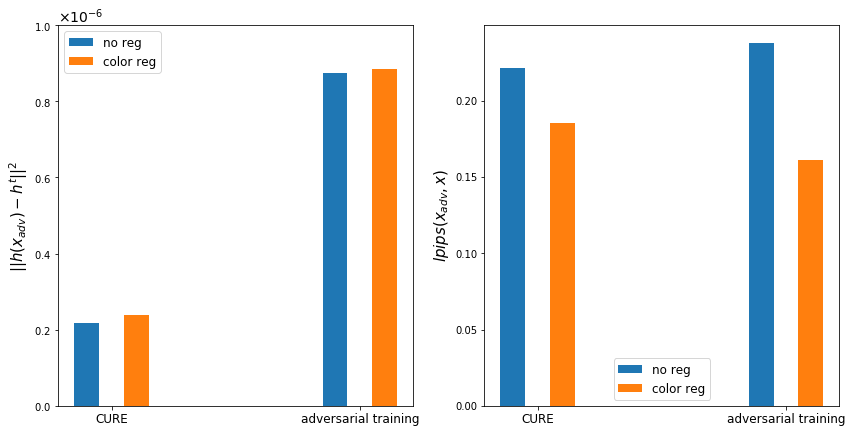

In [32]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

x_s = np.array([1,2])
ax[0].bar(x_s - 0.1, 
           [mse_to_target_map_ciede["CURE"]["add"], mse_to_target_map_ciede["adv_train_RN50"]["add"]], width=0.1, label="no reg")

ax[0].bar(x_s + 0.1, 
           [mse_to_target_map_ciede["CURE"]["add_reg"], mse_to_target_map_ciede["adv_train_RN50"]["add_reg"]], width=0.1, label="color reg")


ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=1e-6)

ax[1].bar(x_s - 0.1, 
           [lpips_to_original_image_ciede["CURE"]["add"], lpips_to_original_image_ciede["adv_train_RN50"]["add"]], width=0.1, label="no reg")

ax[1].bar(x_s + 0.1, 
           [lpips_to_original_image_ciede["CURE"]["add_reg"], lpips_to_original_image_ciede["adv_train_RN50"]["add_reg"]], width=0.1, label="color reg")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[1].legend(fontsize=12)
ax[1].set_ylabel(r"$lpips(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse_ciede_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

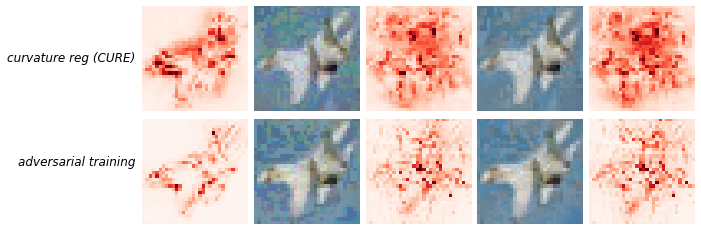

In [40]:


fig, ax = plt.subplots(2, 5, figsize=(10, 4))


viz.visualize_image_attr(np.transpose(expl_cure.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)


for i, method in enumerate(["CURE", "adv_train_RN50"]):
    for j, att in enumerate(["add", "add_reg"]):
        perturbed_img = p_img_ciede[method][att]
        ax[i, 2*j+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
        viz.visualize_image_attr(np.transpose(p_expl_ciede[method][att].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[i, 2*j+2]), use_pyplot=False)
#################
for i in range(2):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
# ax[0, 0].set_title("saliency", fontsize=12)
# ax[0, 1].set_title("smooth grad", fontsize=12)
# ax[0, 2].set_title("uniform grad", fontsize=12)
# fig.text(0.12, 0.75, 'standard training', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.69, 'curvature reg (CURE)', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.33, 'adversarial training', style = 'oblique', fontsize = 12, horizontalalignment ='right')

# fig.text(0.12, 0.2, 'add+stadv+recolor', style = 'oblique', fontsize = 10, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("compare_attacks_viz_cifar_ciede.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

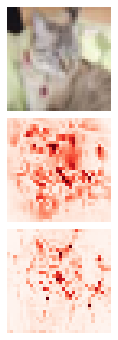

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(2, 6))

ax[0].imshow(torch_to_image(normalizer.forward(target_img), data_mean, data_std))

target_expl = get_expl(model_cure, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(target_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

target_expl = get_expl(model_adv_train, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(target_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2]), use_pyplot=False)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("target_expl_map_ciede_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);